Compare performances of `onepbiter!` and `onebpiter_slow!`

In [160]:
include("../code/headers.jl")
using BenchmarkTools
seed = 1234

1234

In [118]:
sizes = [100, 500, 1000, 5000, 10000, 50000]
N = length(sizes)
times = zeros(N)
for i in 1:N
    n = sizes[i]; m = Int(3/5*n)
    times[i] = @belapsed LossyModel(Val(2), n, m, randseed=seed)
end

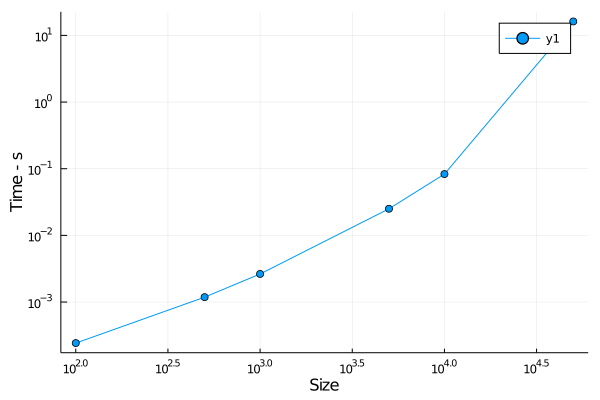

In [120]:
plot(sizes, times, scale=:log10, marker=:circle, ylabel="Time - s", xlabel="Size")

In [164]:
n = 10000
m = 6000
seed = 1234
algo = MS(maxiter = 100, Tmax=1, gamma=1e-3, sigma=1e-10, convergence=:messages, tol=-1.0)
lm1 = LossyModel(Val(2), n, m, randseed=seed)
lm2 = deepcopy(lm1)
independent = falses(n)
basis = lightbasis(lm1.fg, independent);

Slow version:

In [166]:
@btime solve!($lm1, $algo, randseed=$seed, oneiter! = $onebpiter_slow!, independent = $independent, basis= $basis);

  913.312 ms (10000692 allocations: 899.79 MiB)


Fast version:

In [165]:
@btime solve!($lm2, $algo, randseed=$seed, oneiter! = $onebpiter!, independent = $independent, basis= $basis);

  68.208 ms (592 allocations: 2.56 MiB)


## Distortion in time

In [167]:
function bp_track_distortion!(fg::FactorGraph, algo::Union{BP,MS}, y::Vector{Int},
    codeword=falses(algo.maxiter),
    maxchange=fill(NaN, algo.maxiter); randseed::Int=0, neutral=neutralel(algo,fg.q),
    verbose::Bool=false, showprogress::Bool=verbose, oneiter!::Function=onebpiter!, 
    independent::BitArray{1}=falses(fg.n), basis=lightbasis(fg, independent),
    distortions = fill(NaN,algo.maxiter))

    randseed != 0 && Random.seed!(randseed)      # for reproducibility
    newguesses = zeros(Int,fg.n)
    oldguesses = guesses(fg)
    par = parity(fg)
    wait_time = showprogress ? 1 : Inf
    n = 0
    
    refresh!(fg)
    extfields!(fg,y,algo,randseed=randseed)

    fact_perm = randperm(fg.m)

    for trial in 1:algo.Tmax
        prog = ProgressMeter.Progress(algo.maxiter, wait_time, 
            "Trial $trial/$(algo.Tmax) ")
        for t in 1:algo.maxiter
            maxchange[t] = oneiter!(fg, algo, neutral, fact_perm=fact_perm)
            shuffle!(fact_perm)
            newguesses,oldguesses = oldguesses,newguesses
            newguesses .= guesses(fg)
            par = parity(fg, newguesses)
            codeword[t] = (par==0)
            if algo.convergence == :messages
                if maxchange[t] <= algo.tol
                    return BPResults{typeof(algo)}(converged=true, parity=par,
                        distortion=distortion(fg, y), trials=trial, iterations=t,
                        codeword=codeword, maxchange=maxchange)
                end
            elseif algo.convergence == :decvars
                if newguesses == oldguesses
                    n += 1
                    if n >= algo.nmin
                        return BPResults{typeof(algo)}(converged=true, parity=par,
                        distortion=distortion(fg, y), trials=trial, iterations=t,
                        codeword=codeword, maxchange=maxchange)
                    end
                else
                    n=0
                end
            elseif algo.convergence == :parity
                if par == 0
                    showprogress && println()
                    return BPResults{typeof(algo)}(converged=true, parity=par,
                        distortion=distortion(fg, y), trials=trial, iterations=t,
                        codeword=codeword, maxchange=maxchange)
                end
            else
                error("Field convergence must be one of :messages, :decvars, :parity")
            end
            algo.gamma != 0 && reinforce!(fg, algo)
            ProgressMeter.next!(prog)
            distortions[t] = algo.default_distortion(fg,y,independent=independent,
                basis=basis)
#              distortions[t] = distortion(fg, y)
        end
        if trial != algo.Tmax
            # If convergence not reached, re-initialize random fields and start again
            refresh!(fg)
            extfields!(fg,y,algo,randseed=randseed+trial)
            fill!(maxchange, NaN)
            n = 0
        end
    end
    return BPResults{typeof(algo)}(converged=false, parity=par,
                distortion=algo.default_distortion(fg,y,independent=independent,
                basis=basis), trials=algo.Tmax, 
                iterations=algo.maxiter, codeword=codeword, 
                maxchange=maxchange)
end

bp_track_distortion! (generic function with 3 methods)

In [168]:
lm1 = LossyModel(Val(2), n, m, randseed=seed)
algo = MS(maxiter = 1000, Tmax=1, gamma=1e-3, sigma=1e-10, convergence=:messages, tol=-1.0) 
distortions = fill(NaN,algo.maxiter)
bp_track_distortion!(lm1.fg, algo, lm1.y, distortions=distortions)

BPResults{MS}
  converged: Bool false
  parity: Int64 0
  distortion: Float64 0.1856
  trials: Int64 1
  iterations: Int64 1000
  maxdiff: Array{Float64}((0,)) Float64[]
  codeword: BitArray{1}
  maxchange: Array{Float64}((1000,)) [3.0000000000213127, 2.0069999995934573, 2.007008999959303, 2.013027017640058, 2.009014009764473, 2.0100431281180935, 2.0080210278379536, 1.024176745794774, 1.024454035322497, 1.031329267721887  …  283.8146984342857, 294.6799511879108, 278.2379716059477, 290.6492718956051, 276.75890587534013, 279.40495444786393, 265.32413833478495, 270.0518036614121, 333.36193093372094, 350.78051304673136]


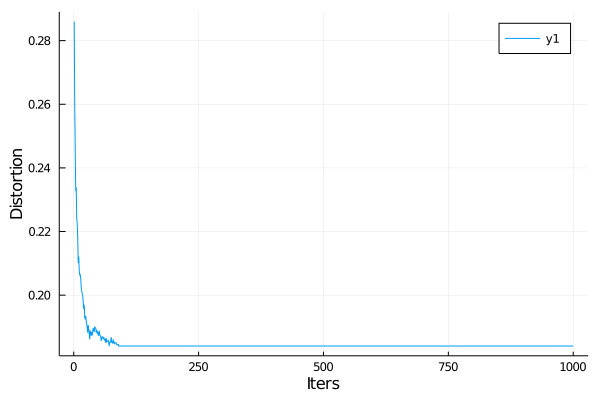

In [149]:
plot(1:algo.maxiter, distortions, xlabel="Iters", ylabel="Distortion")